<a href="https://colab.research.google.com/github/ebriantar/BrianAntar/blob/main/Properati_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **The data set and problem to solve:**  
At this oportunity we are going to work with the Properati's dataset. Properati it's a real estate company, the objective of this project is to use theirs current database to create a model that helps to predict the price of properties based on the property characteristics.

### **Stage I: Data Transformation**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
properati = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_Proyecto_01_Datos_Properati.csv')
properati.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


**Outliers detection and traitment:**

As a first step we are going to analyze the Property_type parameter, since it is the variable that most segments the dataset (it is not the same to quote a house than an apartment). In this way we are going to remove variability from the dataset, so we will be focused on the property types that represent 95% of the dataset. In this way, we are focusing the project on being able to predict the price of those types of properties that have the most weight when it comes to having to quote.

In [5]:
tipos = round(100*(properati ['property_type'].value_counts(normalize=True)),2)
# tipos = tipos.astype(int)
print(tipos)

Departamento       73.18
Casa               14.67
PH                  9.75
Lote                0.89
Oficina             0.45
Otro                0.26
Local comercial     0.22
Casa de campo       0.22
Depósito            0.18
Cochera             0.18
Name: property_type, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'Tipo de propiedad')

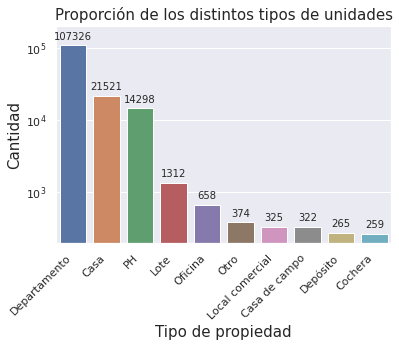

In [6]:
grafico_tipos = sns.countplot(data = properati, x = "property_type", log=True, 
                        order = properati['property_type'].value_counts().index)

for p in grafico_tipos.patches:
    grafico_tipos.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0, 200000)
plt.xticks(rotation = 45, ha='right')
plt.title('proportion of property types', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.xlabel('Property Type', fontsize=15)

As we can saw in the graph and the table of values, the set of **Apartments, Houses and PHs represents 97% of the total dataset**, which is why the dataset will be filtered and now we'll be working with those type of properties.

In [7]:
#Filtro los tipos de propiedad hasta quedarme con el 95% del dataset --> Casas, Dptos, PH

properati_f_type = properati.loc[((properati.property_type == 'Departamento') | (properati.property_type == 'Casa') | (properati.property_type == 'PH'))]

In [8]:
#Filter of no sense values:

#Statement: Surface Covered > Total Surface
properati_f = properati_f_type.loc[(properati_f_type.surface_covered <= properati_f_type.surface_total)]
    
#Statement: Number of bedrooms > Number of rooms
properati_f = properati_f.loc[(properati_f.bedrooms <= properati_f.rooms)]

Next, we will analize the behavior of the different variables by using a describe:

In [9]:
properati_f.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,113805.000000,113805.000000,122182.000000,122182.000000,120519.000000,122182.000000,122182.000000,1.221820e+05
mean,-34.598050,-58.462737,3.119641,2.057717,1.587990,183.295665,103.573456,2.436988e+05
std,0.095081,0.139432,1.371891,1.065946,0.873401,1449.778307,738.147166,2.968997e+05
min,-35.150806,-59.042416,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,-34.620027,-58.499596,2.000000,1.000000,1.000000,52.000000,47.000000,1.150000e+05
50%,-34.598170,-58.443019,3.000000,2.000000,1.000000,78.000000,67.000000,1.700000e+05
75%,-34.571673,-58.410616,4.000000,3.000000,2.000000,137.000000,107.000000,2.680000e+05
max,-34.171414,-57.805832,35.000000,15.000000,14.000000,169000.000000,126062.000000,3.243423e+07


**The statistics of each attribute will be analyzed below in order to understand which of them may or may not be useful to us:**

**Bedrooms:**
Mean = 2.96, Std Deviation = 1.31  
We can see that when comparing the mean and the deviation, the last one is very large with respect to the mean (it represents 44%). So you could say that there would be a big error using this statistics.


**Bedrooms:**
Mean = 1.96, Std Deviation = 1.07  
We can see that when comparing the mean and the deviation, the latter is very large with respect to the mean (it represents 54%). So you could say that there would be a big error using this statistics.


**Bathrooms:**
Mean = 1.56, Std Deviation = 0.86  
We can see that when comparing the mean and the deviation, the latter is very large with respect to the mean (it represents 55%). So you could say that there would be a big error using this statistics.


**Total area:**
Means = 112.62, Deviation Std = 980.71  
We can see that the deviation is greater than the mean.


**Covered area:**
Means = 94.96, Std Deviation = 778.51  
We can see that the deviation is greater than the mean.


**Price:**
Means = 259500, Deviation Std = 322265  
We can see that the deviation is greater than the mean.

**We will analize the behavior of the variable "Total Area", in order to adopt a method that allows eliminate outliers:**  
We will start by analizeing the distribution of the variable with a boxplot.

Text(0.5, 1.0, 'Superfice Total')

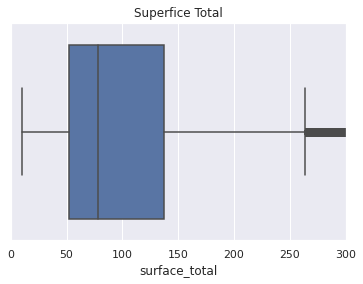

In [16]:
sns.boxplot(data = properati_f, x = 'surface_total')
plt.xlim(0,300)
plt.title('Surface Total')

As we can see in the box plot, the variable total surface presents a positive asymmetry.
To eliminate the extreme values, a method based on the interquartile range will be used, but unlike the conventional method in which 1.5 * IQR is added and subtracted from the values ​​of Q3 and Q1, respectively, what we are going to do is to take a minimum value appropriate to the variable in question (as we see in the graph, the minimum values ​​are not a serious problem) and limit the maximum value to Q3 + 1.5 * IQR. In this way, an attempt is made to adapt the method to a variable with positive skewness, avoiding that the lower limit goes to negative values ​​that are meaningless, since the original method is designed for a normal distribution.

Before proceeding with the filtering of extreme values, the behavior of the total surface variable will be analyzed according to the type of property. In this way, it is sought to avoid the bias of averaging the behavior and values ​​of the variable and incurring possible errors when filtering, since, for example, houses may have on average a greater total surface area than apartments and it would be a mistake to apply the same filtering for both property types.

Text(0.5, 1.0, 'Superfice Total')

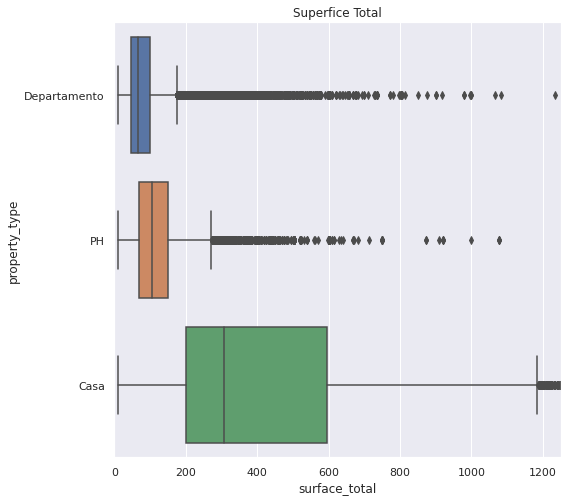

In [11]:
plt.figure(figsize=(8,8))
sns.boxplot(data = properati_f, x = 'surface_total', y='property_type')
plt.xlim(0,1250)
plt.title('Surface Total')

As we can see, the total surface variable has a positive asymmetry for the three types of property, so we are going to apply the method mentioned above. But it is also noticeable that the total area is distributed around very different values depending on the type of property in question, that is why the interquartile method will be applied for each type of property in order to establish the upper limit of said variable.

In [18]:
properati_dpto = properati_f.loc[(properati_f.property_type=='Departamento')]
Q1_dpto = properati_dpto['surface_total'].quantile (0.25) 
Q3_dpto = properati_dpto['surface_total'].quantile (0.75)  
IQR_dpto = Q3_dpto - Q1_dpto 

properati_casa = properati_f.loc[(properati_f.property_type=='Casa')]
Q1_casa = properati_casa['surface_total'].quantile (0.25) 
Q3_casa = properati_casa['surface_total'].quantile (0.75)  
IQR_casa = Q3_casa - Q1_casa 


properati_PH = properati_f.loc[(properati_f.property_type=='PH')]
Q1_PH = properati_PH['surface_total'].quantile (0.25) 
Q3_PH = properati_PH['surface_total'].quantile (0.75) 
IQR_PH = Q3_PH - Q1_PH 


properati_f = properati_f.loc[(((properati_f.property_type=='Departamento') & ((20 <= properati_f.surface_total) & (properati_f.surface_total <= (Q3_dpto+1.5*IQR_dpto))))|
                                 ((properati_f.property_type=='Casa') & ((20 <= properati_f.surface_total) & (properati_f.surface_total <= (Q3_casa+1.5*IQR_casa))))|
                                ((properati_f.property_type=='PH') & ((20 <= properati_f.surface_total) & (properati_f.surface_total <= (Q3_PH+1.5*IQR_PH)))))]
properati_f.shape

(113493, 19)

**We will analize the behavior of the variable "Price", in order to adopt a method that allows eliminate outliers:**  
We will start by analizeing the distribution of the variable with a boxplot.

Text(0.5, 1.0, 'Precio')

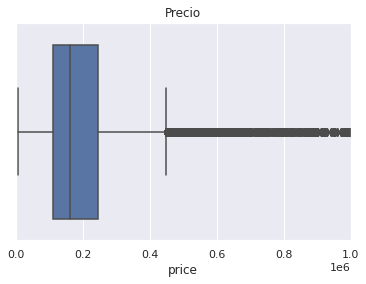

In [20]:
sns.boxplot(data = properati_f, x = 'price')
plt.xlim(0,1000000)
plt.title('Price')

As we can see in the box plot, the variable price presents a positive asymmetry.
To eliminate the extreme values, a method based on the interquartile range will be used, but unlike the conventional method in which 1.5 * IQR is added and subtracted from the values ​​of Q3 and Q1, respectively, what we are going to do is to take a minimum value appropriate to the variable in question (as we see in the graph, the minimum values ​​are not a serious problem) and limit the maximum value to Q3 + 1.5 * IQR. In this way, an attempt is made to adapt the method to a variable with positive skewness, avoiding that the lower limit goes to negative values ​​that are meaningless, since the original method is designed for a normal distribution.

Before proceeding with the filtering of extreme values, the behavior of the price variable will be analyzed according to the type of property. In this way, it is sought to avoid the bias of averaging the behavior and values ​​of the variable and incurring possible errors when filtering, since, for example, houses may have on average a different price range than apartments and it would be a mistake to apply the same filtering for both property types.

Text(0.5, 1.0, 'Precio')

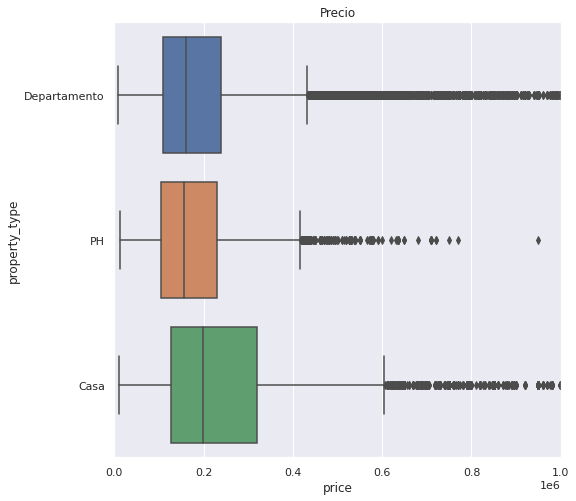

In [21]:
plt.figure(figsize=(8,8))
sns.boxplot(data = properati_f, x = 'price', y='property_type')
plt.xlim(0,1000000)
plt.title('Price')

As we can see, the price variable has a positive asymmetry for the three types of property, so we are going to apply the method mentioned above. But it is also noticeable that the total area is distributed around very different values depending on the type of property in question, that is why the interquartile method will be applied for each type of property in order to establish the upper limit of said variable.

In [22]:
properati_dpto = properati_f.loc[(properati_f.property_type=='Departamento')]
Q1_dpto = properati_dpto['price'].quantile (0.25) 
Q3_dpto = properati_dpto['price'].quantile (0.75) 
Q0_dpto = properati_dpto['price'].quantile (0)
IQR_dpto = Q3_dpto - Q1_dpto 

properati_casa = properati_f.loc[(properati_f.property_type=='Casa')]
Q1_casa = properati_casa['price'].quantile (0.25) 
Q3_casa = properati_casa['price'].quantile (0.75) 
Q0_casa = properati_casa['price'].quantile (0) 
IQR_casa = Q3_casa - Q1_casa 


properati_PH = properati_f.loc[(properati_f.property_type=='PH')]
Q1_PH = properati_PH['price'].quantile (0.25) 
Q3_PH = properati_PH['price'].quantile (0.75) 
Q0_PH = properati_PH['price'].quantile(0) 
IQR_PH = Q3_PH - Q1_PH 



properati_f = properati_f.loc[(((properati_f.property_type=='Departamento') & ((20000 <= properati_f.price) & (properati_f.price <= (Q3_dpto+1.5*IQR_dpto))))|
                                 ((properati_f.property_type=='Casa') & ((20000 <= properati_f.price) & (properati_f.price <= (Q3_casa+1.5*IQR_casa))))|
                                ((properati_f.property_type=='PH') & ((20000 <= properati_f.price) & (properati_f.price <= (Q3_PH+1.5*IQR_PH)))))]

properati_f.shape

(107739, 19)

**Encodig:  
At this point we will try to transform a categorical variable into a numerical one to be able to include it in the prediction models and increase its prediction capacity:**

As a first step, we are going to make the encodeing of the variable property_type:

In [23]:
encode_1 = pd.get_dummies(properati_f.property_type)
properati = properati_f.drop(['property_type'], axis=1)
properati = pd.concat([properati, encode_1], axis=1)
properati.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,operation_type,Casa,Departamento,PH
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Venta,0,1,0
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,Venta,0,0,1
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",Venta,0,0,1
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,Venta,0,0,1
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,Venta,0,0,1


Now we are going to make the same traitment with the variable l2 (Location):

In [24]:
encode_2 = pd.get_dummies(properati.l2)
properati = properati.drop(['l2'], axis=1)
properati = pd.concat([properati, encode_2], axis=1)
properati.head()

,start_date,end_date,created_on,lat,lon,l1,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,operation_type,Casa,Departamento,PH,Bs.As. G.B.A. Zona Norte,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Venta,0,1,0,0,0,0,1
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,Venta,0,0,1,0,0,0,1
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",Venta,0,0,1,0,0,0,1
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,Venta,0,0,1,0,0,0,1
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,Venta,0,0,1,0,0,1,0


**Imputation of missing values:**

At this point, a treatment of the missing values will be carried out, in order to be able to estimate them and have more data for prediction.


In [25]:
properati.isna().sum()

start_date                     0
end_date                       0
created_on                     0
lat                         6667
lon                         6667
l1                             0
l3                             0
rooms                          0
bedrooms                       0
bathrooms                   1530
surface_total                  0
surface_covered                0
price                          0
currency                       0
title                          0
description                    0
operation_type                 0
Casa                           0
Departamento                   0
PH                             0
Bs.As. G.B.A. Zona Norte       0
Bs.As. G.B.A. Zona Oeste       0
Bs.As. G.B.A. Zona Sur         0
Capital Federal                0
dtype: int64

As we can see there are 3 categories that have missing values, 'lat', 'lon' and 'bathrooms'. In order to impute a value in those missing cases, we are going to apply two techniques:



*   'lat 'and' lon ': For these variables we are going to fill in the missing ones with the average value of each case, since, when dealing with latitudes and longitudes of properties so close (all properties are in Bs.As) we would not be making a big mistake when imputing the values with the average value, since all the lat and lon will be very close.

*   'Bathrooms': To fill in the number of bathrooms we are going to use as an imputation technique a KNN Neighbors model, in which we will use the covered surface as a reference variable, since, as we will see later, it is the variable with the that has the highest correlation.


**Imputing missing values for latitude and longitude:**

In [26]:
properati ['lat'].fillna(value=properati['lat'].mean(), inplace=True)
properati ['lon'].fillna(value=properati['lon'].mean(), inplace=True)

**Imputing missing values for number of bathrooms:**

To carry out the imputation with a model of neighboring KNNs, we are going to analyze the variable with the highest correlation with the bathrooms:

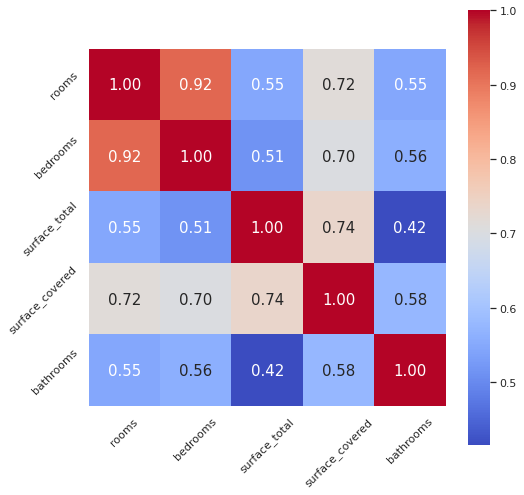

In [27]:
corr = properati[['rooms', 'bedrooms', 'surface_total', 'surface_covered', 'bathrooms']].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},           
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [28]:
nuevo = properati[['surface_covered', 'bathrooms']]
nuevo

,surface_covered,bathrooms
0,140.0,2.0
1,58.0,2.0
2,45.0,1.0
3,50.0,1.0
4,35.0,1.0
...,...,...
146655,48.0,1.0
146656,90.0,2.0
146657,35.0,1.0
146658,38.0,1.0


In [29]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
nuevo = imputer.fit_transform(nuevo)

In [34]:
nuevo = pd.DataFrame(nuevo)
nuevo = nuevo.astype(int)
nuevo.columns = ['surface_covered', 'bathrooms']
nuevo

,surface_covered,bathrooms
0,140,2
1,58,2
2,45,1
3,50,1
4,35,1
...,...,...
107734,48,1
107735,90,2
107736,35,1
107737,38,1


In [36]:
properati = properati.drop(['bathrooms'], axis=1)
properati.reset_index(drop = True, inplace=True)
properati = pd.concat([properati, nuevo.bathrooms], axis=1)
properati.head()

,start_date,end_date,created_on,lat,lon,l1,l3,rooms,bedrooms,surface_total,surface_covered,price,currency,title,description,operation_type,Casa,Departamento,PH,Bs.As. G.B.A. Zona Norte,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal,bathrooms
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,San Cristobal,7.0,7.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Venta,0,1,0,0,0,0,1,2
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Boedo,2.0,1.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,Venta,0,0,1,0,0,0,1,2
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Palermo,2.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",Venta,0,0,1,0,0,0,1,1
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Palermo,2.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,Venta,0,0,1,0,0,0,1,1
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,La Plata,2.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,Venta,0,0,1,0,0,1,0,1


### **Stage II: Prediction Models**

### **Random Forest Regressor**

First we are going to run the model with its default hyperparameters and evaluate it, then we will seek to optimize its hyperparameters through Grid Search, to again evaluate and compare with the previous ones.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import scipy as sp
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

RF_simple = RandomForestRegressor()
RF_simple_mse = cross_validate(RF_simple, X_train, y_train, cv=5,scoring=('neg_mean_squared_error'), return_train_score=True)

In [ ]:
print("Root mean square error in train is:", np.sqrt((-1)*RF_simple_mse['train_score'].mean()))
print("Root mean square error in train is:", np.sqrt((-1)*RF_simple_mse['test_score'].mean()))

Raíz del error cuadrático medio en test es: 30010.72165997254
Raíz del error cuadrático medio en test es: 47680.6656236718


**Now, we are going to optimize the hyperparameters and compare the models:**




In [ ]:
%%time
param_grid_rf = {'n_estimators' : [100, 150],
              'criterion': ['mse'], 
              'max_depth': [2, 4, 8, 10, 12],
              'min_samples_split':np.arange(2, 4) }

random_forest = RandomForestRegressor()

grid_search = GridSearchCV(random_forest, param_grid=param_grid_rf, cv=5, n_jobs = -1,  return_train_score = True)
grid_search.fit(X_train, y_train)

CPU times: user 17.1 s, sys: 682 ms, total: 17.7 s
Wall time: 8min 57s


In [ ]:
grid_search.best_params_

{'criterion': 'mse',
 'max_depth': 12,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
best_RF = grid_search.best_estimator_ 
y_train_pred = best_RF.predict(X_train)
y_test_pred = best_RF.predict(X_test)

rmse_train_best_RF = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
rmse_test_best_RF = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))


print("Root mean square error in train is:", (rmse_train_best_RF.round(2)))
print("Root mean square error in train is:", (rmse_test_best_RF.round(2)))

Raíz del error cuadrático medio en train es: 44434.19
Raíz del error cuadrático medio en test es: 49857.16


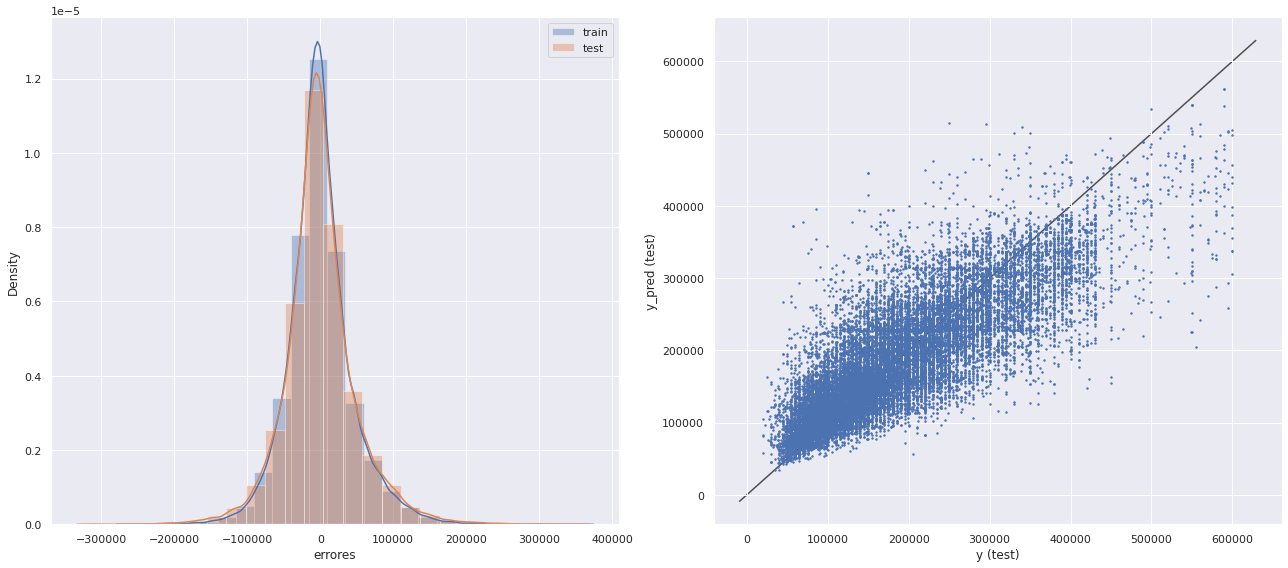

In [ ]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize = (18,8))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 25, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 25, label = 'test')
plt.xlabel('Error')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

**Here, we are going to analyze the importance of the attributes for the model, in addition, 3 trees will be chosen at random and the same analysis will be made but focused particularly on said tree:**

We analyze the importance that the model gives to each attribute:

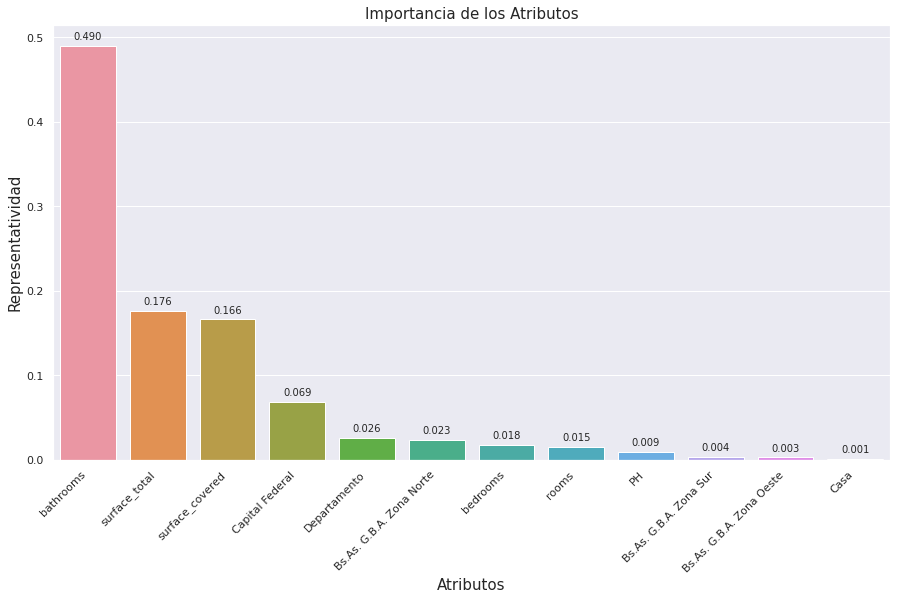

In [ ]:
importances = best_RF.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
grafico = sns.barplot(columns[indices], importances[indices])


for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation = 45, ha='right')
plt.title('Importance of Attributes', fontsize=15)
plt.ylabel('Representativeness', fontsize=15)
plt.xlabel('Attributes', fontsize=15)
plt.show()

We choose a first tree at random and analyze the importance
which gives each attribute:

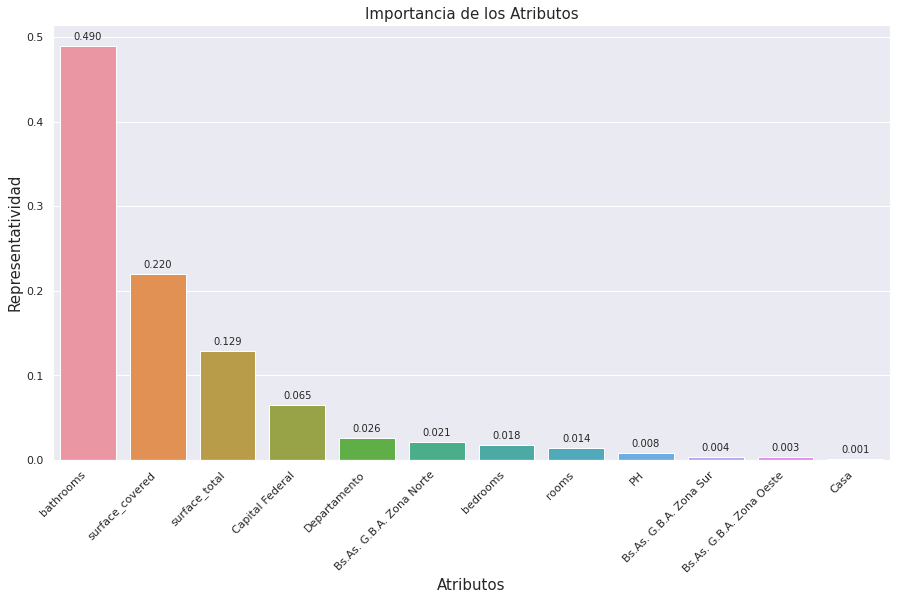

In [ ]:
tree_1 = best_RF.estimators_[50]

importances_1 = tree_1.feature_importances_
columns = X_train.columns
indices = np.argsort(importances_1)[::-1]

plt.figure(figsize = (15,8))
grafico = sns.barplot(columns[indices], importances_1[indices])


for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation = 45, ha='right')
plt.title('Importance of Attributes', fontsize=15)
plt.ylabel('Representativeness', fontsize=15)
plt.xlabel('Attributes', fontsize=15)
plt.show()

We choose a second tree at random and analyze the importance
which gives each attribute:

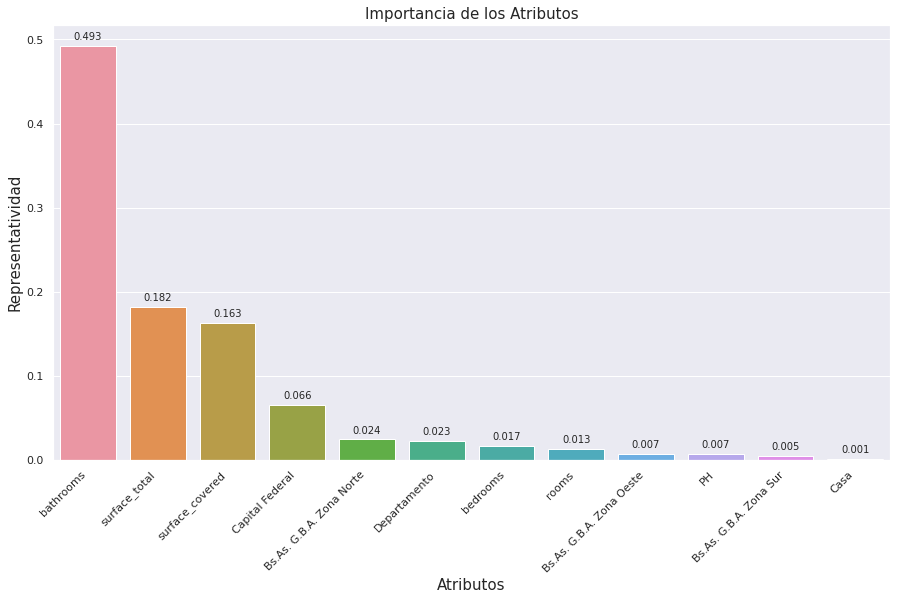

In [ ]:
tree_2 = best_RF.estimators_[40]

importances_2 = tree_2.feature_importances_
columns = X_train.columns
indices = np.argsort(importances_2)[::-1]

plt.figure(figsize = (15,8))
grafico = sns.barplot(columns[indices], importances_2[indices])


for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation = 45, ha='right')
plt.title('Importance of Attributes', fontsize=15)
plt.ylabel('Representativeness', fontsize=15)
plt.xlabel('Attributes', fontsize=15)
plt.show()

We choose a third tree at random and analyze the importance
which gives each attribute:

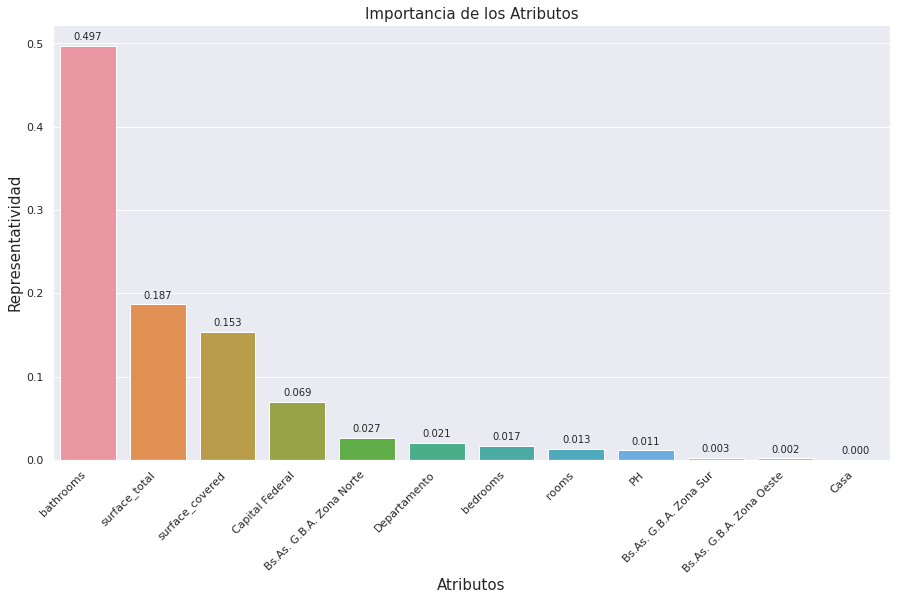

In [ ]:
tree_3 = best_RF.estimators_[30]

importances_3 = tree_3.feature_importances_
columns = X_train.columns
indices = np.argsort(importances_3)[::-1]

plt.figure(figsize = (15,8))
grafico = sns.barplot(columns[indices], importances_3[indices])


for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation = 45, ha='right')
plt.title('Importance of Attributes', fontsize=15)
plt.ylabel('Representativeness', fontsize=15)
plt.xlabel('Attributes', fontsize=15)
plt.show()

### **XGBoost:**

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

XGBRegressor_simple = XGBRegressor(silent=1)
XGBRegressor_simple_scores = cross_validate(XGBRegressor_simple, X_train, y_train, cv=5, scoring=('neg_mean_squared_error'), return_train_score=True)


In [ ]:
print("Raíz del error cuadrático medio en train es:", round(np.sqrt((-1)*XGBRegressor_simple_scores['train_score'].mean()))
print("Raíz del error cuadrático medio en test es:", round(np.sqrt((-1)*XGBRegressor_simple_scores['test_score'].mean()))

Raíz del error cuadrático medio en train es: 53675.22578375763
Raíz del error cuadrático medio en test es: 54053.41794708266


In [ ]:
%%time

XGBRegressor_opt = XGBRegressor()

param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [5, 7, 10],
        'min_child_weight': [1, 3],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [200, 500],
        'objective': ['reg:squarederror']}


grid_search_XGB = GridSearchCV(estimator = XGBRegressor_opt,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_squared_error',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search_XGB.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 44.6min


In [ ]:
print("Best Parameters: "+str(grid_search_XGB.best_params_))

In [ ]:
best_XGB = grid_search_XGB.best_estimator_
    
y_train_pred_XGB = best_XGB.predict(X_train)
y_test_pred_XGB = best_XGB.predict(X_test)

rmse_train_best_XGB = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_XGB))
rmse_test_best_XGB = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_XGB))


print("Raíz del error cuadrático medio en train es:", (rmse_train_best_XGB.round(2)))
print("Raíz del error cuadrático medio en test es:", (rmse_test_best_XGB.round(2)))


In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_XGB, bins = 50, label = 'train')
sns.distplot(y_test - y_test_pred_XGB, bins = 50, label = 'test')
plt.xlabel('Error')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_XGB, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

### **Comparison and selection of models:**

**The following table will show the scores of each model, so we can analyze them and select the predictor model that have the best prediction performance:**

| Model                    | RMSE train   | RMSE test    | Selection   |
| :----------------:       | :---------:  | :---------:  | :---------: |
| Random Forest            |    30.018    |    47.660    |             |
| Random Forest Optimized |    44.449    |    49.882    |<img src=https://i.ibb.co/d60z9fF/Sin-t-tulo.png> |
| XGBOOST                  |    53.675    |    54.053    |             |
| XGBOOST Optimized       |    33.337    |    47.596    |             |


First we are going to analyze the RMSE of the test, as we can see the best models in this indicator are the Random Forest, the Optimized XGBOOST and the Optimized Random Forest. It is easy to notice that the first two present the best RMSE test values, but we can observe that there is a great difference in both cases between the RMSE train and the test (differences of the order of 30/40%), which indicates that the model presents a lot of variance. On the other hand, if we analyze the Optimized Random Forest, we can see that although the RMSE test is not the least, it is very close to the previous ones and in this case the difference between the RMSE train / test is not a problem, so it does not present great variance nor a great bias (since it is between the optimal error values), that is why the selected model is the Optimized Random Forest Reggressor.


### **Stage 3: Model Interpretation**

**What variables were relevant to the model to make a prediction? Which not?. If you used an assembly model in trees, in addition to seeing the importance of each attribute, also choose some trees at random and see which attributes you consider important. How are these trees different? Why? Finally, answer, does it match what you expected from your experience with this dataset?**

As can be seen when the importance of attributes was analyzed for the Random Forest Reggresor model, the most representative attributes were:

1.   Cantidad de Baños   (49%)
2.   Superficie Total    (17%)
1.   Superficie Cubierta (16%)
2.   CABA                (6,8%)
1.   Departamento        (2,5%) 

When some trees were randomly analyzed, it was noted that the most important attributes for them always conincide in the order of importance and perhaps the percentages of representativeness varied in a very low order, but all were in very similar orders.
This order of importance makes sense and is what I expected, since in the previous project the model that obtained the best performance was the one that had in its explanatory variables the number of bathrooms, the covered area and the number of rooms. It should be noted that as expected, and that is why this encodeing was carried out, among the most important variables are CABA and Department, which are variables that in the previous project were not used in the prediction models because they are categorical variables and as this lack of preprocessing was believed, valuable information was lost when creating a prediction model.
I want to highlight the importance of the variable number of bathrooms, which is greater than that given in the previous project, this may be due to the imputation of missing values ​​that was carried out in this project, managing to use important data that in the project 1 were dismissed and important information was lost.









**How is the error distribution? Where does it fail? For what is this?**

As we can see if we look at the error graphs in the previous section, where the selected model was run:

1.   Los errores RMSE son similares tanto para test como para train, indicando que no hay un gran sobreajuste.
2.   Los histogramas de los errores son simétricos, aproximadamente gaussianos, y parecidos para ambos conjuntos. Esto es un indicador de que estamos aproximando a nuestros datos de manera correcta.

1. The RMSE errors are similar for both test and train, indicating that there is not a large overfitting.
2. The histograms of the errors are symmetric, approximately Gaussian, and similar for both sets. This is an indicator that we are approximating our data correctly.

The model fails to a greater extent when it tries to predict properties with a high listed price, this is due to the fact that these properties are the least representative within the dataset and are probably properties with particularities to be analyzed separately, which raise their price and the model does not achieve represent it properly, since it was trained for most of the dataset which are more frequent and market value properties pulling towards the mean and not towards the upper end.

**Conclusions:**

Regarding the work methodology, I am in agreement with the way of structuring the analysis, I managed to clearly understand the importance of a good data pre-processing, the advantages of imputing values ​​with adequate methodologies so as not to lose information, as well as the need to normalize data for better overall performance. I would have liked to generate functions that allowed me to generate more models and alternatives to analyze different performances depending on the explanatory variables.
Regarding the methodology used in the advanced models part, in the future, instead of optimizing the models through a grid search and then comparing them, what I would do is generate many models with their default hyperparameters and then dedicate time to optimization only to the winning model, in this way I'll save more time, processing resources and I dedicate analysis time exclusively to the most important model.

I want to be critical about the model generated and the information used for the analysis, a price prediction model that obtains an average error of usd 50,000 approx. it is very poor, since the error is very significant compared to the property value. Likewise, this result was to be expected, since the database is very small with respect to the real spectrum, it would be interesting to be able to integrate several real estate databases in order to have a more representative sample of the population. If I had to improve something in the formulation of the prediction model, the first thing I would look for is to generate a numerical variable to represent the location of the property with more accuracy and information. We could do this, for example, by generating an index per neighborhood in which a weighting is made of how good that neighborhood is in different categories, such as points of interest, tourism, security, education, transportation, etc. in this way we would include in the analysis information that is important when estimating the price of a property, by means of a numerical variable.